In [217]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.cross_validation import cross_val_score
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn import manifold, decomposition, linear_model, ensemble, neighbors, cross_validation
%matplotlib inline
import seaborn as sns
import sklearn
import matplotlib.pyplot as plt

from heamy.dataset import Dataset
from heamy.estimator import Regressor, Classifier
from heamy.pipeline import ModelsPipeline

import xgboost as xgb

In [218]:
def rmse(x,y):
    return np.mean((x - y) ** 2) ** 0.5

## Подготовка данных (urls)

In [219]:
urls_train_df = pd.read_csv('data/url_domain_train', header=None, delimiter='\t')
urls_train_df.columns = ['id', 'url', 'Count']
#urls_train_df = urls_train_df[['id', 'url']]

In [220]:
urls_train_df.head()

,id,url,Count
0,000000014B60815F65B38258011B6C01,login.rutracker.org,1
1,000000014B60815F65B38258011B6C01,rutracker.org,4
2,000000014C03DA2A47AC433A0C755201,admin.tour-spb.net,1
3,000000014C03DA2A47AC433A0C755201,czinfo.ru,1
4,000000014C03DA2A47AC433A0C755201,forumsostav.ru,1


In [221]:
urls_train_df.url = urls_train_df.url.apply(lambda x: ".".join(x.split(".")[:-1]))
urls_train_df.url = urls_train_df.url.apply(lambda x: x+" ")
urls_train_df.url = urls_train_df.url.multiply(urls_train_df.Count)
urls_train_df.url = urls_train_df.url.apply(lambda x: x.strip())
urls_train_df.url = urls_train_df.url.apply(lambda x: ' '.join(x.split(' ')))

urls_train_df.url.head()

0                            login.rutracker
1    rutracker rutracker rutracker rutracker
2                             admin.tour-spb
3                                     czinfo
4                                forumsostav
Name: url, dtype: object

In [222]:
urls_train_df = pd.DataFrame(urls_train_df.groupby('id')['url'].apply(lambda x: x.tolist()))
urls_train_df['id'] = urls_train_df.index
urls_train_df.index = range(len(urls_train_df))
urls_train_df.columns = ['urls', 'id']

In [223]:
age_train_df = pd.read_csv('data/age_profile_train', header=None, delimiter='\t')
age_train_df.columns = ['id', 'age']

In [224]:
ages = age_train_df.age.value_counts().reset_index()
ages.columns = ["age", "cnt"]

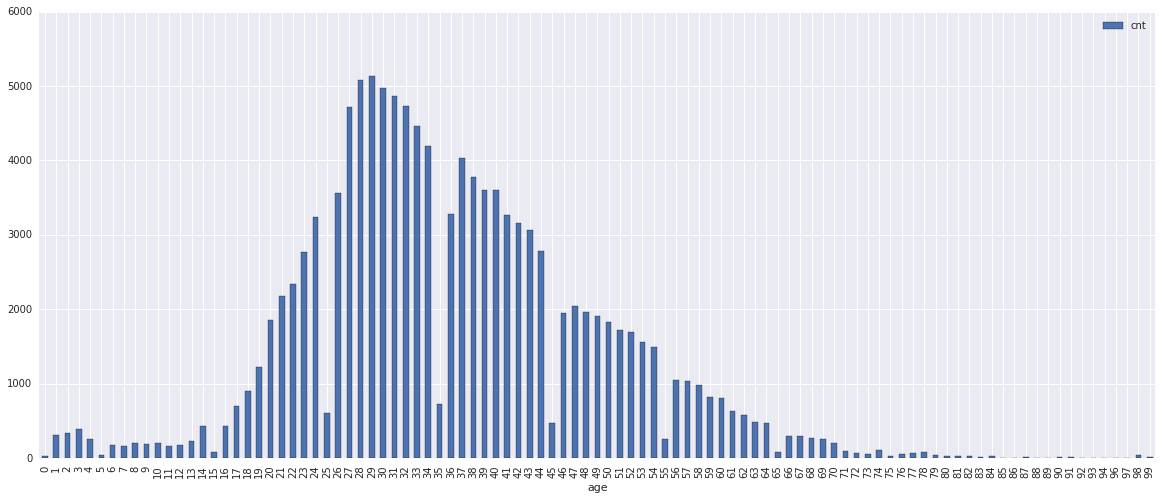

In [225]:
ages.sort_values(by="age").set_index("age").plot(kind="bar", figsize=(20, 8))

провалы через каждые 10 лет!! 5-15-25-35-45-55-65-

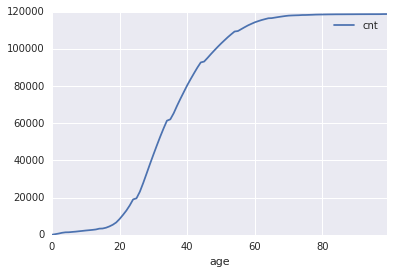

In [226]:
ages.sort_values(by="age").set_index("age").cumsum().plot()

In [227]:
r = ages.sort_values(by="age").set_index("age").cumsum()

In [228]:
interval_labels = [22, 26, 29, 31, 34, 38, 41, 46, 53]  # побъем cussum по 10 равновероятным интервалам

In [229]:
pd.options.display.max_rows = 100
r/118679

,cnt
age,
0,0.000244
1,0.002907
2,0.005797
3,0.009134
4,0.011257
5,0.011561
6,0.013010
7,0.014324
8,0.016060


In [1]:
0.195468 - 0.109708


0.08576

In [16]:
train_df = urls_train_df.merge(age_train_df, on='id', how='left')

In [17]:
train_df.head()

,urls,id,age
0,"[id.rambler, mail.rambler, r0]",000000013CB5719C0000A2C90002C101,53
1,"[1prime, autorambler, chellak, docs.cntd docs....",00000001442BE24000001B7D00F50801,48
2,[bosch-korolev],00000001448580F800003F1B31FB0901,28
3,"[aptekanizkihcen, colady, gorod.dp, i.ovkuse, ...",0000000145BDB2FF000157971645E901,44
4,"[astrorok, diets, edaplus, eshzdorovo, gotovim...",000000014602771F0000DB9359714C01,48


In [87]:
prob_urls = pd.read_csv('allset_prob_urls.csv')
prob_urls20 = pd.read_csv('allset_prob_urls_20.csv')
prob_urls100 = pd.read_csv('allset_prob_urls_100.csv')

## Снижение размерности

In [23]:
train_df.head()

,urls,id,age
0,"[id.rambler, mail.rambler, r0]",000000013CB5719C0000A2C90002C101,53
1,"[1prime, autorambler, chellak, docs.cntd docs....",00000001442BE24000001B7D00F50801,48
2,[bosch-korolev],00000001448580F800003F1B31FB0901,28
3,"[aptekanizkihcen, colady, gorod.dp, i.ovkuse, ...",0000000145BDB2FF000157971645E901,44
4,"[astrorok, diets, edaplus, eshzdorovo, gotovim...",000000014602771F0000DB9359714C01,48


In [96]:
X, y = train_df.urls.values, train_df.age.values

In [97]:
X[:5]

array([['id.rambler', 'mail.rambler', 'r0'],
       ['1prime', 'autorambler', 'chellak', 'docs.cntd docs.cntd', 'echo.msk echo.msk', 'expert expert expert expert expert expert expert', 'finance.rambler finance.rambler', 'forbes forbes', 'forum.ixbt', 'garant', 'govoritmoskva', 'kommersant', 'kp', 'lenta', 'mait', 'metronews', 'mk', 'news.rambler news.rambler news.rambler news.rambler news.rambler news.rambler news.rambler news.rambler news.rambler news.rambler news.rambler news.rambler news.rambler news.rambler news.rambler news.rambler news.rambler news.rambler news.rambler news.rambler', 'news.smi2', 'norm-load', 'pfr.kirov', 'pfrf', 'photography-on-the', 'realty.rambler', 'ren ren ren ren ren', 'riafan', 'rns rns rns rns rns rns rns rns rns rns rns rns rns', 'rossbanki', 'secretmag', 'tehnorma', 'tiu', 'top68', 'tvc', 'tvzvezda', 'vesti', 'video.rambler video.rambler', 'weekend.rambler'],
       ['bosch-korolev'],
       ['aptekanizkihcen', 'colady', 'gorod.dp', 'i.ovkuse', 'love.ma

In [98]:
X, y = train_df.urls.values, train_df.age.values

In [99]:
%%time
X = map(lambda x: ' '.join(x), X)
hw = HashingVectorizer(n_features=1000, non_negative=True).fit(X)
X = hw.transform(X).todense()

CPU times: user 10.8 s, sys: 260 ms, total: 11.1 s
Wall time: 11 s


In [100]:
X.shape

(118603, 1000)

In [101]:
%%time
transformer = sklearn.decomposition.NMF(n_components=100)
X_nmf = transformer.fit_transform(X)

CPU times: user 1h 7min 34s, sys: 35min 11s, total: 1h 42min 46s
Wall time: 10min 46s


## Холдаут

In [102]:
itrain, itest = cross_validation.train_test_split(range(len(X)), test_size=1./3, random_state=0)
len(itrain), len(itest)

(79068, 39535)

## Обучение модели

In [103]:
rmse(y[itest], np.mean(y[itrain]))

12.546984607126014

In [104]:
normed = prob_urls[prob_urls.columns[1:-2]].div(prob_urls.all_cnt, axis='rows')
normed20 = prob_urls20[prob_urls20.columns[1:-2]].div(prob_urls20.all_cnt, axis='rows')
normed100 = prob_urls100[prob_urls100.columns[1:-2]].div(prob_urls100.all_cnt, axis='rows')

In [105]:
normed20.head()

,0,1,2,3,4
0,0.058105,0.563029,0.328262,0.048247,0.002357
1,0.037745,0.438305,0.432725,0.087394,0.003831
2,0.333333,0.666667,0.000000,0.000000,0.000000
3,0.045086,0.551354,0.348889,0.053302,0.001369
4,0.052382,0.615786,0.296990,0.033420,0.001422


In [119]:
X2 = np.hstack([X, normed])

In [120]:
%%time
reg = LinearRegression(n_jobs=-1)
reg.fit(X2[itrain, :], y[itrain])

pred_X = reg.predict(X2[itest, :])

CPU times: user 1min 2s, sys: 2min 2s, total: 3min 5s
Wall time: 15.2 s


In [121]:
print rmse(y[itest], pred_X)

11.8517982642


In [131]:
X_nmf2 = np.hstack([X_nmf, normed])

In [132]:
reg = LinearRegression()
reg.fit(X_nmf2[itrain, :], y[itrain])

pred_X_nmf = reg.predict(X_nmf2[itest, :])
print rmse(y[itest], pred_X_nmf)

11.8895259047


11.8229322719


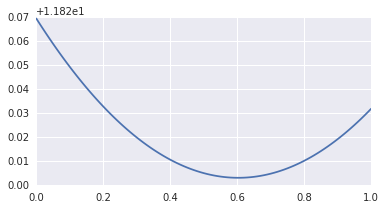

In [133]:
error = []
for w in np.linspace(0, 1, 101):
     error += [rmse(y[itest], pred_X * w + (1-w) * pred_X_nmf)]

pd.Series(error, index=np.linspace(0, 1, 101)).plot(figsize=(6,3))
print min(error)

In [ ]:
w = 0.6

pred_X * w + (1-w) * pred_X_nmf


## Blenging с помощью heamy
pip install heamy

https://github.com/rushter/heamy

In [58]:
from sklearn import pipeline, preprocessing, feature_extraction

In [60]:
#%%time

dataset1 = Dataset(X[itrain, :], y[itrain], X[itest, :]) # обычный датасет

dataset2 = Dataset(X_nmf[itrain, :], y[itrain], X_nmf[itest, :]) # NMF


# линейная модель на обычных данных
lr = Regressor(dataset=dataset1, 
                     estimator=linear_model.LinearRegression,
                     parameters={'normalize': True},
                     name='lr')

# линейная модель на TFIDF от обычных данных
def tfidf_lr_(X_train, y_train, X_test, y_test=None, random_state=8888):
    model = pipeline.Pipeline([('tfidf', feature_extraction.text.TfidfTransformer()), 
                                ('linear_model', linear_model.LinearRegression())])
    model.fit(X_train, y_train)
    return model.predict(X_test)

tfidf_lr = Regressor(dataset=dataset1,
                     estimator=tfidf_lr_,
                     name='tfidf_lr')

"""xgb_regr1 = Regressor(dataset=dataset1, 
                     estimator=xgb.XGBRegressor,
                     parameters={'n_estimators': 1500, 'max_depth':5, 'learning_rate': 0.03,
                                'subsample': 0.6, 'colsample_bytree': 0.9, 'colsample_bylevel':0.7},
                     name='xgb_regr1')"""

# ExtraTrees на NMF
rf = Regressor(dataset=dataset2, 
                     estimator=ensemble.ExtraTreesRegressor,
                     parameters={'n_estimators': 100, 'n_jobs': -1},
                     name='rf')

"""xgb_regr2 = Regressor(dataset=dataset2, 
                     estimator=xgb.XGBRegressor,
                     parameters={'n_estimators': 5000, 'max_depth':3, 'learning_rate': 0.01,
                                'subsample': 0.6, 'colsample_bytree': 0.9, 'colsample_bylevel':0.7},
                     name='xgb_regr2')
"""
# Stack four models
# Returns new dataset with out-of-fold predictions
meta_pipeline = ModelsPipeline(lr, tfidf_lr,rf)
stack_ds = meta_pipeline.blend(proportion=0.2,seed=111)

# Train LinearRegression on stacked data (second stage)
stacker = Regressor(dataset=stack_ds, estimator=LinearRegression)
results = stacker.predict()

In [61]:
print 'ok'

ok


In [62]:
print rmse(y[itest], results)

11.7088339144


In [117]:
stack_ds.X_train.head()

,0,1,2,3,4
0,33.167411,32.573229,32.357552,32.223092,32.626858
1,36.701791,37.685494,38.468842,40.220000,41.834999
2,42.919375,45.058823,44.136963,41.352000,44.891705
3,34.676553,35.206553,35.601051,31.890000,31.693237
4,40.021339,40.215771,40.047886,35.370000,34.146587


In [107]:
results[:10]

array([ 35.58590565,  35.9381726 ,  36.49681817,  33.0223584 ,
        35.9381726 ,  41.72288112,  35.82528573,  35.73381191,
        32.12228247,  36.9305902 ])

parameter tuning

In [134]:
param = {}
param['max_depth'] = 5
param['booster'] = 'gbtree'
param['objective'] = 'reg:linear'
param['eval_metric'] = 'rmse'
param['eta'] = 0.01
param['subsample'] = 0.6
param['colsample_bytree'] = 0.9
param['colsample_bylevel'] = 0.7
"""param['min_child_weight'] = 1
param['gamma'] = 0.1
param['reg_alpha'] = 1e-05
param['scale_pos_weight'] = 1"""

numround = 1000

In [135]:
X_all_datatrain = xgb.DMatrix(stack_ds.X_train, label = stack_ds.y_train)

In [136]:
xgb.cv(param, X_all_datatrain, num_boost_round=5000, nfold=3, metrics="rmse", \
       verbose_eval=10, as_pandas=False, seed=27)

[0]	train-rmse:37.3736+0.128331	test-rmse:37.3733+0.262893
[10]	train-rmse:34.1734+0.115152	test-rmse:34.178+0.272762
[20]	train-rmse:31.3115+0.105381	test-rmse:31.3212+0.280507
[30]	train-rmse:28.7588+0.0963254	test-rmse:28.7754+0.285157
[40]	train-rmse:26.4907+0.0886859	test-rmse:26.5161+0.288185
[50]	train-rmse:24.4706+0.0779949	test-rmse:24.5059+0.294173
[60]	train-rmse:22.684+0.0710022	test-rmse:22.7306+0.295201
[70]	train-rmse:21.1081+0.065187	test-rmse:21.1669+0.294361
[80]	train-rmse:19.7226+0.0590204	test-rmse:19.7955+0.294638
[90]	train-rmse:18.5114+0.0571258	test-rmse:18.5979+0.289914
[100]	train-rmse:17.4559+0.0554815	test-rmse:17.5572+0.284698
[110]	train-rmse:16.5398+0.0551697	test-rmse:16.6574+0.278598
[120]	train-rmse:15.7487+0.0526917	test-rmse:15.8824+0.269143
[130]	train-rmse:15.0685+0.0515516	test-rmse:15.2185+0.259684
[140]	train-rmse:14.4853+0.0532131	test-rmse:14.6517+0.249776
[150]	train-rmse:13.9879+0.0534115	test-rmse:14.1705+0.24049
[160]	train-rmse:13.5673+0

KeyboardInterrupt: 

### Обучаем на все

In [138]:
urls_test_df = pd.read_csv('data/url_domain_test', header=None, delimiter='\t')
urls_test_df.columns = ['id', 'url', 'Count']


In [139]:
urls_test_df.url = urls_test_df.url.apply(lambda x: ".".join(x.split(".")[:-1]))
urls_test_df.url = urls_test_df.url.apply(lambda x: x+" ")
urls_test_df.url = urls_test_df.url.multiply(urls_test_df.Count)
urls_test_df.url = urls_test_df.url.apply(lambda x: x.strip())
urls_test_df.url = urls_test_df.url.apply(lambda x: ' '.join(x.split(' ')))

urls_test_df.url.head()

0               afisha afisha
1                         aif
2    aimfar.solution.weborama
3                    alkotest
4                   aptekamos
Name: url, dtype: object

In [140]:
urls_test_df = pd.DataFrame(urls_test_df.groupby('id')['url'].apply(lambda x: x.tolist()))
urls_test_df['id'] = urls_test_df.index
urls_test_df.index = range(len(urls_test_df))
urls_test_df.columns = ['urls', 'Id']

In [141]:
urls_test_df.head()

,urls,Id
0,"[1000bankov, 1tv 1tv 1tv 1tv 1tv 1tv 1tv 1tv, ...",000000014A02348E701552980349FF01
1,"[autorambler, bilettorg, dsol-druzhba, family....",000000014A10EA183BF8594A0B2AB201
2,[photosight photosight photosight photosight p...,000000014A4FE5C33A929D4C26943601
3,"[base.consultant, dogovor-obrazets, fd, mail.r...",000000014B7BB9957784A9BC0AC9F401
4,"[assessor assessor, audit-it, base.garant, com...",000000014C7749F896D82C2B01E8B801


In [143]:
Xtest = urls_test_df.urls.values
Xtest = map(lambda x: ' '.join(x), Xtest)
Xtest = hw.transform(Xtest).todense()

In [144]:
%%time
Xtest_nmf = transformer.fit_transform(Xtest)

CPU times: user 9min 53s, sys: 12min 24s, total: 22min 17s
Wall time: 1min 42s


In [153]:
%%time

# обычный датасет
dataset1 = Dataset(X, y, Xtest)
# NMF
dataset2 = Dataset(X_nmf, y, Xtest_nmf)

# линейная модель на обычных данных
lr = Regressor(dataset=dataset1, 
                     estimator=linear_model.LinearRegression,
                     parameters={'normalize': True},
                     name='lr')

# линейная модель на TFIDF от обычных данных
tfidf_lr = Regressor(dataset=dataset1,
                     estimator=tfidf_lr_,
                     name='tfidf_lr')


xgb_regr1 = Regressor(dataset=dataset1, 
                     estimator=xgb.XGBRegressor,
                     parameters={'n_estimators': 1500, 'max_depth':5, 'learning_rate': 0.03,
                                'subsample': 0.6, 'colsample_bytree': 0.9, 'colsample_bylevel':0.7},
                     name='xgb_regr1')

# ExtraTrees на NMF
rf = Regressor(dataset=dataset2, 
                     estimator=ensemble.ExtraTreesRegressor,
                     parameters={'n_estimators': 100, 'n_jobs': -1},
                     name='rf')

xgb_regr2 = Regressor(dataset=dataset2, 
                     estimator=xgb.XGBRegressor,
                     parameters={'n_estimators': 5000, 'max_depth':3, 'learning_rate': 0.01,
                                'subsample': 0.6, 'colsample_bytree': 0.9, 'colsample_bylevel':0.7},
                     name='xgb_regr2')


# Stack three models
# Returns new dataset with out-of-fold predictions
meta_pipeline = ModelsPipeline(lr, tfidf_lr, xgb_regr1, rf, xgb_regr2)
stack_ds = meta_pipeline.blend(proportion=0.2,seed=111)

# Train LinearRegression on stacked data (second stage)
stacker = Regressor(dataset=stack_ds, estimator=LinearRegression)
results = stacker.predict()
#print rmse(y[itest], results)

CPU times: user 3h 58min 51s, sys: 2min 31s, total: 4h 1min 22s
Wall time: 10min 48s


In [196]:
results.shape

(39535,)

In [172]:
results

array([ 43.31582941,  40.78575566,  38.39462095, ...,  36.02755276,
        36.91845768,  39.41990555])

In [173]:
sample_df = pd.read_csv('sample_submission.csv')

In [174]:
sample_df.head()

,Id,age
0,000000014A02348E701552980349FF01,36.04347
1,000000014A10EA183BF8594A0B2AB201,36.04347
2,000000014A4FE5C33A929D4C26943601,36.04347
3,000000014B7BB9957784A9BC0AC9F401,36.04347
4,000000014C7749F896D82C2B01E8B801,36.04347


In [175]:
sample_df.age.shape

(19979,)

In [176]:
miss_idx = set(sample_df.Id.values) - set(urls_test_df.Id.values)
miss_idx  ## есть 

{'00000001545483F30F717F5A0721E401',
 '00000046549F9C26429C4B0159BFEE01',
 '000000465684D839B64B58DA9701F701',
 '000022D456544DE3771122F857A6F201',
 '06210D9556EFE0E30000054678B0D901'}

In [177]:
miss_df = pd.DataFrame(zip(list(miss_idx), age_train_df.age.mean()* np.ones(len(miss_idx))))
miss_df.columns = ['Id', 'age']

In [178]:
miss_df

,Id,age
0,000022D456544DE3771122F857A6F201,36.04347
1,06210D9556EFE0E30000054678B0D901,36.04347
2,00000046549F9C26429C4B0159BFEE01,36.04347
3,00000001545483F30F717F5A0721E401,36.04347
4,000000465684D839B64B58DA9701F701,36.04347


In [179]:
urls_test_df["age"] = results

In [180]:
urls_test_df.head()

,urls,Id,age
0,"[1000bankov, 1tv 1tv 1tv 1tv 1tv 1tv 1tv 1tv, ...",000000014A02348E701552980349FF01,43.315829
1,"[autorambler, bilettorg, dsol-druzhba, family....",000000014A10EA183BF8594A0B2AB201,40.785756
2,[photosight photosight photosight photosight p...,000000014A4FE5C33A929D4C26943601,38.394621
3,"[base.consultant, dogovor-obrazets, fd, mail.r...",000000014B7BB9957784A9BC0AC9F401,33.773400
4,"[assessor assessor, audit-it, base.garant, com...",000000014C7749F896D82C2B01E8B801,39.143206


In [181]:
all_set = urls_test_df.merge(miss_df, how='outer')[["Id", "age"]]

In [182]:
all_set.head()

,Id,age
0,000000014A02348E701552980349FF01,43.315829
1,000000014A10EA183BF8594A0B2AB201,40.785756
2,000000014A4FE5C33A929D4C26943601,38.394621
3,000000014B7BB9957784A9BC0AC9F401,33.773400
4,000000014C7749F896D82C2B01E8B801,39.143206


In [183]:
all_set.sort_values(by="Id").to_csv("stacking_2xgb_add_counts.csv", index=False)

### Blending

In [205]:
from sklearn.datasets import load_boston
from sklearn.cross_validation import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

data = load_boston()
X, y = data['data'], data['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=111)

# create dataset
dataset = Dataset(X_train,y_train,X_test)

# initialize RandomForest & LinearRegression
model_rf = Regressor(dataset=dataset, estimator=RandomForestRegressor, parameters={'n_estimators': 50},name='rf')
model_lr = Regressor(dataset=dataset, estimator=LinearRegression, parameters={'normalize': True},name='lr')

# Stack two models
# Returns new dataset with out-of-fold predictions
pipeline = ModelsPipeline(model_rf,model_lr)
stack_ds = pipeline.blend(proportion=0.2,seed=111)

# Train LinearRegression on stacked data (second stage)
stacker = Regressor(dataset=stack_ds, estimator=LinearRegression)
results = stacker.predict()
# Validate results using 10 fold cross-validation

results = stacker.validate(k=10,scorer=mean_absolute_error)

Metric: mean_absolute_error
Folds accuracy: [2.755382922586739, 1.2983953827322219, 1.3451751317571223, 4.1691449980020421, 1.8335534158242497, 1.4252855488443406, 3.796561897196681, 3.8740508440436909, 1.340474784189877, 3.5524672699816815]
Mean accuracy: 2.53904921952
Standard Deviation: 1.15038810562
Variance: 1.32339279355


### Stacking

In [206]:
# load boston dataset from sklearn
from sklearn.datasets import load_boston
data = load_boston()
X, y = data['data'], data['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=111)

# create dataset
dataset = Dataset(X_train,y_train,X_test)

# initialize RandomForest & LinearRegression
model_rf = Regressor(dataset=dataset, estimator=RandomForestRegressor, parameters={'n_estimators': 50},name='rf')
model_lr = Regressor(dataset=dataset, estimator=LinearRegression, parameters={'normalize': True},name='lr')

# Stack two models
# Returns new dataset with out-of-fold predictions
pipeline = ModelsPipeline(model_rf,model_lr)
stack_ds = pipeline.stack(k=10,seed=111)

# Train LinearRegression on stacked data (second stage)
stacker = Regressor(dataset=stack_ds, estimator=LinearRegression)
results = stacker.predict()
# Validate results using 10 fold cross-validation
results = stacker.validate(k=10,scorer=mean_absolute_error)

Metric: mean_absolute_error
Folds accuracy: [2.5069203640457021, 1.5176036689604795, 1.8612766231086197, 2.017107551973409, 2.6330917029607543, 2.6845105953359787, 1.7472546610358961, 2.5915132949288715, 2.3777447931954878, 2.4314089150184524]
Mean accuracy: 2.23684321706
Standard Deviation: 0.394993297327
Variance: 0.156019704933


### Weighted average

In [211]:
from sklearn.neighbors import KNeighborsRegressor
dataset = Dataset(X_train,y_train,X_test)

model_rf = Regressor(dataset=dataset, estimator=RandomForestRegressor, parameters={'n_estimators': 151},name='rf')
model_lr = Regressor(dataset=dataset, estimator=LinearRegression, parameters={'normalize': True},name='lr')
model_knn = Regressor(dataset=dataset, estimator=KNeighborsRegressor, parameters={'n_neighbors': 15},name='knn')

pipeline = ModelsPipeline(model_rf,model_lr,model_knn)

weights = pipeline.find_weights(mean_absolute_error)
result = pipeline.weight(weights)

Best Score (mean_absolute_error): 2.14995315088
Best Weights: [  8.54360869e-01   1.45639131e-01   9.40650559e-17]
